<a href="https://colab.research.google.com/github/phamvanhoangphi13112002/TeslaStockPrediction/blob/master/Predict_Tesla_Closing_Stock_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import neccessary libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

## **Connect to Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Read file**

In [3]:
dataset_filepath = '/content/drive/MyDrive/PROJECTS/Project: Predict Stock Price /tesla_stock.csv'
df = pd.read_csv(dataset_filepath, index_col=0)
df.shape

(1692, 6)

## **EDA the Dataset**

In [4]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [5]:
df.tail()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400,262.049988
3/17/2017,264.000000,265.329987,261.200012,261.500000,6475900,261.500000


In [6]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1692 entries, 6/29/2010 to 3/17/2017
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5+ KB


In [8]:
# check null value
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [10]:
# check duplicated value
df.duplicated().sum()

0

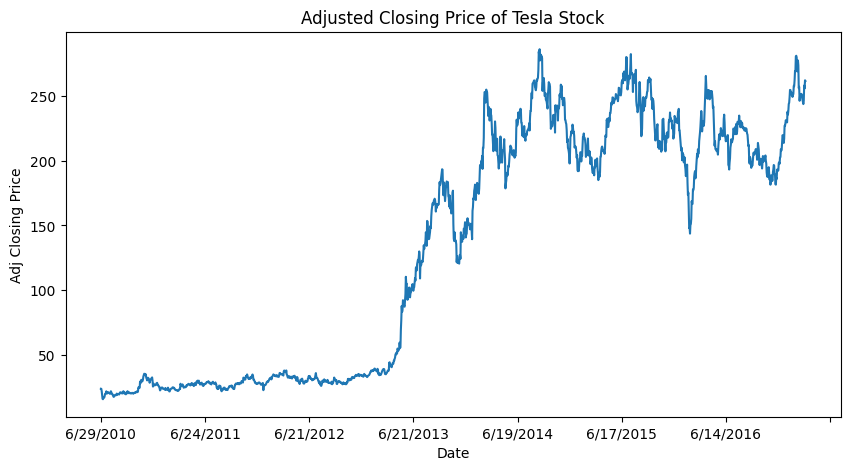

In [11]:
# Visualization of Adjusted Closing Price of Tesla Stock
plt.figure(figsize=(10, 5))
df['Adj Close'].plot()
plt.title('Adjusted Closing Price of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Adj Closing Price')
plt.show()

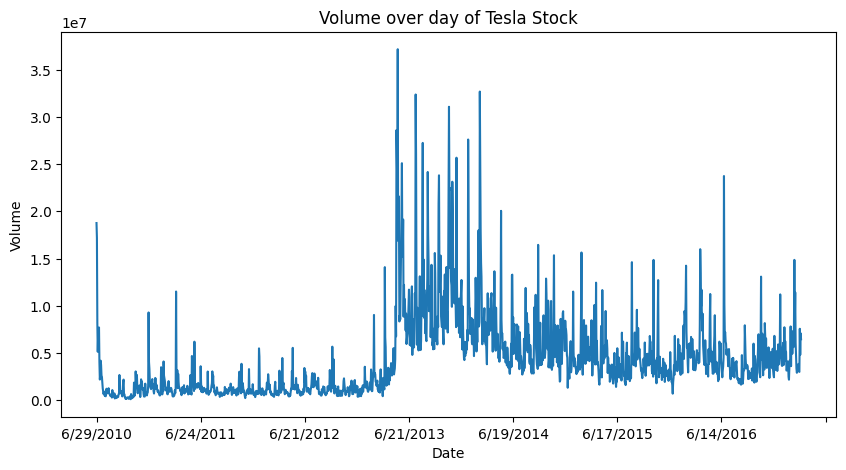

In [12]:
# Visualization of Volume overday of Tesla Stock
plt.figure(figsize=(10, 5))
df['Volume'].plot()
plt.title('Volume over day of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

## **Data Preparation**

In [ ]:
# Declare the Windowing function (used to create X, y pairs for time series data)
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = [] # Declare a list to store X
    labels = [] # Declare a list to store y

    # If df_end_idx equals the last index of the data frame, need to move down by a window size
    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    # Iterate through each data sample
    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[feature_start_idx:feature_end_idx] # Get X
        label = df[label_name][label_start_idx:label_end_idx] # Get y

        features.append(feature)
        labels.append(label)

    # Convert lists to np.ndarrays
    features = np.array(features)
    labels = np.array(labels)

    return features, labels


In [ ]:
dataset_length = len(df)  # Number of data samples in the DataFrame
TRAIN_SIZE = 0.7  # Training set ratio
VAL_SIZE = 0.2  # Validation set ratio
# Convert ratios to indices
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length)
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

In [ ]:

INPUT_SIZE = 30
LABEL_SIZE = 1
OFFSET = 1
BATCH_SIZE = 64
TARGET_NAME = 'Adj Close'


# Initialize X, y for the training set
X_train, y_train = slicing_window(df,
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Initialize X, y for the validation set
X_val, y_val = slicing_window(df,
                              df_start_idx=TRAIN_END_IDX,
                              df_end_idx=VAL_END_IDX,
                              input_size=INPUT_SIZE,
                              label_size=LABEL_SIZE,
                              offset=OFFSET,
                              label_name=TARGET_NAME)

# Initialize X, y for the test set
X_test, y_test = slicing_window(df,
                                df_start_idx=VAL_END_IDX,
                                df_end_idx=None,
                                input_size=INPUT_SIZE,
                                label_size=LABEL_SIZE,
                                offset=OFFSET,
                                label_name=TARGET_NAME)


In [ ]:
# Initilize tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [ ]:
# Configuring and Preparing Data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Build Model**

In [ ]:
# Normalization layer
normalize_layer = tf.keras.layers.Normalization()
normalize_layer.adapt(np.vstack((X_train, X_val, X_test)))

In [ ]:
# Build model
def build_model(input_shape, output_size):
    input_layer = tf.keras.Input(shape=input_shape, name='input_layer')

    x = normalize_layer(input_layer)

    for n_unit in [128, 64]:
        rnn_x = tf.keras.layers.SimpleRNN(n_unit,
                                    return_sequences=True,
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)
                                    )(x)

        lstm_x = tf.keras.layers.LSTM(n_unit,
                                    return_sequences=True,
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)
                                    )(x)

        x = tf.concat([rnn_x, lstm_x], axis=-1)

    rnn_x = tf.keras.layers.SimpleRNN(n_unit,
                                return_sequences=False,
                                kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)
                                )(x)

    lstm_x = tf.keras.layers.LSTM(n_unit,
                                return_sequences=False,
                                kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)
                                )(x)

    x = tf.concat([rnn_x, lstm_x], axis=-1)

    x = tf.keras.layers.Dense(32,
                            activation='relu',
                            kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                            name='fc_layer_1'
                            )(x)

    output_layer = tf.keras.layers.Dense(output_size,
                            kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                            name='output_layer')(x)

    model = tf.keras.Model(input_layer, output_layer, name='combined_model')

    return model

In [ ]:
INPUT_SHAPE = X_train.shape[-2:]
model = build_model(INPUT_SHAPE,
                    LABEL_SIZE)
model.summary()

Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 30, 6)]      0           []                               
                                                                                                  
 normalization (Normalization)  (None, 30, 6)        13          ['input_layer[0][0]']            
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 30, 128)      17280       ['normalization[0][0]']          
                                                                                                  
 lstm (LSTM)                    (None, 30, 128)      69120       ['normalization[0][0]']          
                                                                                     

## **Optimization**

In [ ]:
# hyperparameter values
EPOCHS = 500
LR = 1e-3

In [ ]:
# Some optimization for model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Use optimizer Adam
    loss=tf.keras.losses.MeanSquaredError(), # Use loss Mean Squared Error Function
)

## **Training Model**

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/500
19/19 [==============================] - 20s 352ms/step - loss: 16102.9111 - val_loss: 53220.9688
Epoch 2/500
19/19 [==============================] - 4s 193ms/step - loss: 15403.9639 - val_loss: 52692.9961
Epoch 3/500
19/19 [==============================] - 5s 257ms/step - loss: 14835.9238 - val_loss: 52741.4414
Epoch 4/500
19/19 [==============================] - 5s 234ms/step - loss: 14559.0732 - val_loss: 52505.0703
Epoch 5/500
19/19 [==============================] - 4s 203ms/step - loss: 14246.0273 - val_loss: 52203.9492
Epoch 6/500
19/19 [==============================] - 4s 237ms/step - loss: 13956.8994 - val_loss: 51811.9961
Epoch 7/500
19/19 [==============================] - 5s 243ms/step - loss: 13700.4131 - val_loss: 51375.2070
Epoch 8/500
19/19 [==============================] - 4s 193ms/step - loss: 13476.6221 - val_loss: 50882.6680
Epoch 9/500
19/19 [==============================] - 6s 300ms/step - loss: 13263.6963 - val_loss: 50302.4570
Epoch 10/500
19/19

## **Evaluation**

In [ ]:
def mae(y_true, y_pred):
    mae = np.mean(np.abs((y_true - y_pred)))

    return mae

def mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)

    return mse

def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))

    return rmse

def mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true-y_pred) / y_true)) * 100

    return mape

In [ ]:
y_test_pred = model.predict(X_test, verbose=0)
print(f'RMSE: {rmse(y_test, y_test_pred)}')
print(f'MAPE: {mape(y_test, y_test_pred)}')
print(f'MSE: {mse(y_test, y_test_pred)}')
print(f'MAE: {mae(y_test, y_test_pred)}')

RMSE: 7.08275569019287
MAPE: 2.698402709155248
MSE: 50.16542816695947
MAE: 5.680429943373632


## **Visualization of Result**

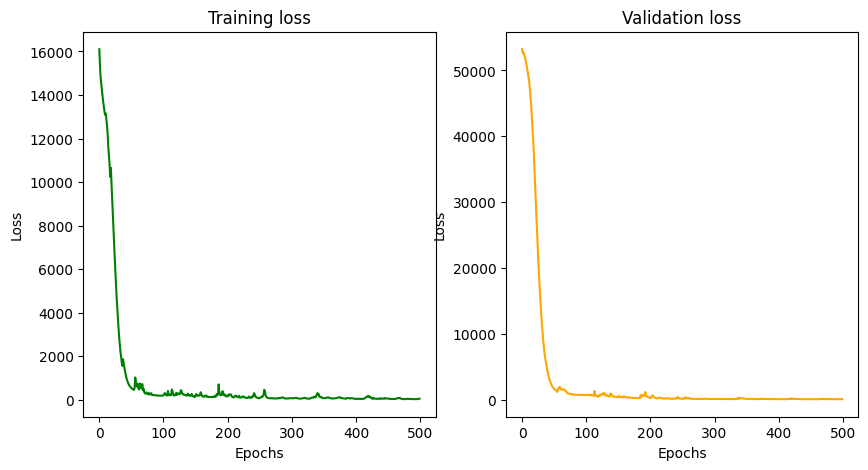

In [ ]:
train_loss = history.history['loss'] # Read training loss information
val_loss = history.history['val_loss'] # Read validation loss information

plt.figure(figsize=(10, 5)) # Set the figure size

plt.subplot(1, 2, 1) # Initialize the plot for training loss
plt.xlabel('Epochs') # Display the x-axis label as 'Epochs'
plt.ylabel('Loss') # Display the y-axis label as 'Loss'
plt.title('Training loss') # Display the title of the current plot as 'Training Loss'
plt.plot(train_loss, color='green') # Plot the training loss values over epochs (plotting in green)

plt.subplot(1, 2, 2) # Initialize the plot for validation loss
plt.xlabel('Epochs') # Display the x-axis label as 'Epochs'
plt.ylabel('Loss') # Display the y-axis label as 'Loss'
plt.title('Validation loss') # Display the title of the current plot as 'Validation loss'
plt.plot(val_loss, color='orange') # Plot the validation loss values over epochs (plotting in orange)

plt.show() # Display both small plots


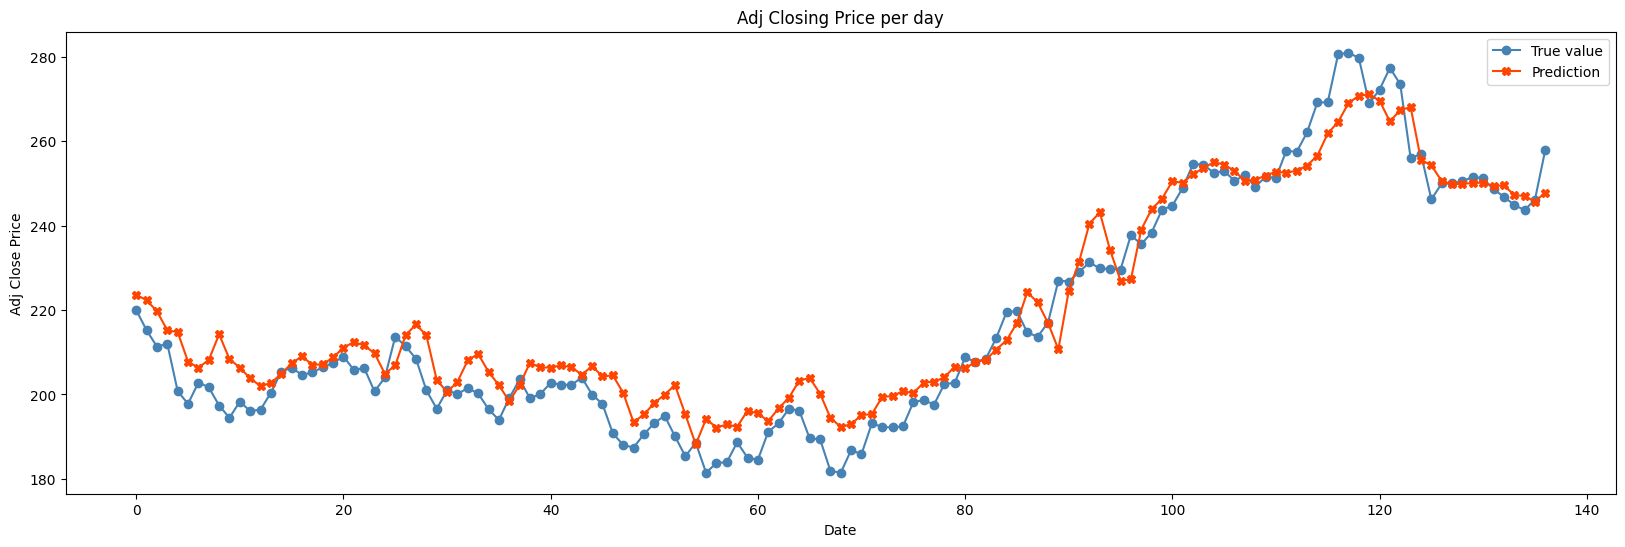

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Adj Closing Price per day')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test[:300], model.predict(X_test[:300], verbose=0))